# 基於牆面追蹤的路徑規劃方法

### 步驟一：牆面識別與分段（Line Detection and Segmentation）
- **理論**：幾何特徵分析
  - 目的：找出連續的牆面段落
  - 方法：
    1. 使用線性回歸找出直線段
    2. 偵測牆面的轉角點
    3. 將牆面分成多個連續段落

### 步驟二：生成牆面追蹤路徑（Parallel Path Generation）
- **理論**：平行路徑生成
  - 目的：生成與牆面平行的安全路徑
  - 方法：
    1. 與牆面保持固定安全距離
    2. 在轉角處生成平滑轉彎
    3. 確保路徑的連續性

### 步驟三：內部區域覆蓋（Interior Coverage）
- **理論**：區域分解與覆蓋
  - 目的：確保完整覆蓋內部空間
  - 方法：
    1. 識別被牆面包圍的內部區域
    2. 在內部區域生成補充路徑
    3. 連接牆面路徑和內部路徑

### 步驟四：路徑優化（Path Optimization）
- **理論**：路徑平滑與優化
  - 目的：確保路徑可執行性
  - 方法：
    1. 平滑轉角處的路徑
    2. 調整速度以適應轉彎
    3. 確保安全距離不變

優點：
1. 更符合實際飛行需求
2. 提高安全性
3. 路徑更有規律性
4. 便於保持定位精度


In [ ]:
pip install numpy open3d scikit-learn scipy networkx matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninst

In [ ]:
import numpy as np
import open3d as o3d
from scipy.spatial import ConvexHull, cKDTree
from scipy.interpolate import splprep, splev
import networkx as nx
from pathlib import Path
import matplotlib.pyplot as plt
import logging
import time

class WallFollowingPlanner:
    def __init__(self, input_dir, output_dir, safety_margin=0.3):
        """
        初始化路徑規劃器

        Args:
            input_dir (str): 輸入點雲文件目錄
            output_dir (str): 輸出結果目錄
            safety_margin (float): 與牆面的安全距離（米）
        """
        self.input_dir = Path(input_dir)
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)
        self.safety_margin = safety_margin

        # 設置日誌
        self.setup_logger()

    def setup_logger(self):
        """設置日誌系統"""
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(self.output_dir / 'processing.log'),
                logging.StreamHandler()
            ]
        )
        self.logger = logging.getLogger(__name__)

    def read_point_cloud(self, pcd_file):
        """
        讀取點雲文件

        Args:
            pcd_file (Path): 點雲文件路徑

        Returns:
            np.ndarray: 點雲數據 (N x 2)
        """
        try:
            pcd = o3d.io.read_point_cloud(str(pcd_file))
            points = np.asarray(pcd.points)
            self.logger.info(f"成功讀取點雲，共 {len(points)} 個點")
            return points[:, :2]  # 只取x,y座標
        except Exception as e:
            self.logger.error(f"讀取點雲失敗: {str(e)}")
            return None

    def ransac_line_fitting(self, points, threshold=0.1, min_points=10, iterations=1000):
        """
        使用RANSAC找出直線

        Args:
            points (np.ndarray): 輸入點集
            threshold (float): 內點閾值
            min_points (int): 最小內點數
            iterations (int): RANSAC迭代次數

        Returns:
            tuple: (內點索引, 直線參數[a,b,c])
        """
        best_inlier_count = min_points
        best_inliers = None
        best_line = None

        for _ in range(iterations):
            # 隨機選擇兩點
            if len(points) < 2:
                continue
            idx = np.random.choice(len(points), 2, replace=False)
            p1, p2 = points[idx]

            # 計算直線參數 ax + by + c = 0
            a = p2[1] - p1[1]
            b = p1[0] - p2[0]
            c = p2[0]*p1[1] - p1[0]*p2[1]
            norm = np.sqrt(a*a + b*b)

            if norm < 1e-10:
                continue

            # 計算所有點到直線距離
            distances = np.abs(a*points[:,0] + b*points[:,1] + c) / norm
            inliers = distances < threshold
            inlier_count = np.sum(inliers)

            if inlier_count > best_inlier_count:
                best_inlier_count = inlier_count
                best_inliers = inliers
                best_line = (a/norm, b/norm, c/norm)

        return best_inliers, best_line

    def detect_walls(self, points):
        """
        檢測牆面並分段

        Args:
            points (np.ndarray): 輸入點雲

        Returns:
            list: 牆面段落列表
        """
        wall_segments = []
        remaining_points = points.copy()

        while len(remaining_points) > 10:
            # 使用RANSAC找出一個牆面
            inliers, line = self.ransac_line_fitting(remaining_points)
            if inliers is None:
                break

            wall_points = remaining_points[inliers]
            if len(wall_points) < 10:
                break

            # 將牆面點按順序排列
            ordered_points = self.order_wall_points(wall_points)
            wall_segments.append(ordered_points)

            # 移除已使用的點
            remaining_points = remaining_points[~inliers]

        self.logger.info(f"檢測到 {len(wall_segments)} 個牆面段落")
        return wall_segments

    def order_wall_points(self, wall_points):
        """
        將牆面點按順序排列

        Args:
            wall_points (np.ndarray): 牆面上的點

        Returns:
            np.ndarray: 排序後的點
        """
        # 計算點之間的距離矩陣
        dist_matrix = np.sqrt(np.sum((wall_points[:,None] - wall_points)**2, axis=2))

        # 找到距離最遠的兩個點作為起點和終點
        i, j = np.unravel_index(np.argmax(dist_matrix), dist_matrix.shape)
        start_point = wall_points[i]

        # 根據到起點的距離排序其他點
        distances = np.sqrt(np.sum((wall_points - start_point)**2, axis=1))
        sorted_indices = np.argsort(distances)

        return wall_points[sorted_indices]

    def generate_parallel_path(self, wall_segments):
        """
        生成平行於牆面的路徑

        Args:
            wall_segments (list): 牆面段落列表

        Returns:
            list: 平行路徑段落列表
        """
        parallel_paths = []
        for segment in wall_segments:
            # 計算牆面方向向量
            direction = segment[-1] - segment[0]
            direction = direction / np.linalg.norm(direction)

            # 計算垂直向量（右手法則）
            normal = np.array([-direction[1], direction[0]])

            # 生成平行路徑點
            parallel_points = segment + normal * self.safety_margin
            parallel_paths.append(parallel_points)

        return parallel_paths

    def connect_path_segments(self, path_segments):
        """
        連接不同的路徑段

        Args:
            path_segments (list): 路徑段落列表

        Returns:
            np.ndarray: 完整的路徑
        """
        if not path_segments:
            return np.array([])

        complete_path = [path_segments[0]]
        remaining_segments = path_segments[1:]

        while remaining_segments:
            current_end = complete_path[-1][-1]

            # 找到最近的下一段路徑
            min_dist = float('inf')
            best_segment = None
            best_reverse = False

            for i, segment in enumerate(remaining_segments):
                # 檢查正向連接
                start_dist = np.linalg.norm(current_end - segment[0])
                if start_dist < min_dist:
                    min_dist = start_dist
                    best_segment = i
                    best_reverse = False

                # 檢查反向連接
                end_dist = np.linalg.norm(current_end - segment[-1])
                if end_dist < min_dist:
                    min_dist = end_dist
                    best_segment = i
                    best_reverse = True

            # 添加最佳連接段
            next_segment = remaining_segments.pop(best_segment)
            if best_reverse:
                next_segment = next_segment[::-1]

            complete_path.append(next_segment)

        return np.vstack(complete_path)

    def smooth_path(self, path):
        """
        平滑路徑

        Args:
            path (np.ndarray): 輸入路徑

        Returns:
            np.ndarray: 平滑後的路徑
        """
        if len(path) < 4:
            return path

        try:
            # 使用B-spline平滑
            tck, u = splprep([path[:,0], path[:,1]], s=0.0, k=min(3, len(path)-1))
            u_new = np.linspace(0, 1, len(path))
            smooth_points = np.column_stack(splev(u_new, tck))
            return smooth_points
        except ValueError:
            # 如果平滑失敗，返回原始路徑
            self.logger.warning("路徑平滑失敗，使用原始路徑")
            return path
        except Exception as e:
            self.logger.error(f"平滑過程發生錯誤: {str(e)}")
            return path

    def process_layer(self, points):
        """
        處理單層點雲

        Args:
            points (np.ndarray): 輸入點雲

        Returns:
            tuple: (最終路徑, 牆面段落)
        """
        # 1. 檢測牆面
        wall_segments = self.detect_walls(points)

        # 2. 生成平行路徑
        parallel_paths = self.generate_parallel_path(wall_segments)

        # 3. 連接路徑段
        complete_path = self.connect_path_segments(parallel_paths)

        # 4. 平滑路徑
        if len(complete_path) > 0:
            smooth_path = self.smooth_path(complete_path)
        else:
            smooth_path = complete_path

        return smooth_path, wall_segments

    def visualize_results(self, points, path, walls, output_file):
        """
        視覺化結果

        Args:
            points (np.ndarray): 原始點雲
            path (np.ndarray): 規劃的路徑
            walls (list): 牆面段落
            output_file (Path): 輸出文件路徑
        """
        plt.figure(figsize=(12, 8))

        # 繪製原始點雲
        plt.scatter(points[:, 0], points[:, 1], c='gray', s=1, alpha=0.5, label='Points')

        # 繪製牆面
        for wall in walls:
            plt.plot(wall[:, 0], wall[:, 1], 'r-', linewidth=1, alpha=0.7)

        # 繪製路徑
        if len(path) > 0:
            plt.plot(path[:, 0], path[:, 1], 'b-', linewidth=2, label='Path')
            plt.plot(path[0, 0], path[0, 1], 'go', label='Start')
            plt.plot(path[-1, 0], path[-1, 1], 'ro', label='End')

        plt.title('Wall Following Path Planning Result')
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')

        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.close()

    def process_all_layers(self):
        """處理所有層的點雲文件"""
        pcd_files = sorted(self.input_dir.glob('*.pcd'))

        for pcd_file in pcd_files:
            self.logger.info(f"處理文件: {pcd_file.name}")
            start_time = time.time()

            # 讀取點雲
            points = self.read_point_cloud(pcd_file)
            if points is None:
                continue

            # 處理單層
            path, walls = self.process_layer(points)

            # 保存結果
            np.save(self.output_dir / f"{pcd_file.stem}_path.npy", path)

            # 視覺化
            self.visualize_results(points, path, walls,
                                 self.output_dir / f"{pcd_file.stem}_result.png")

            processing_time = time.time() - start_time
            if len(path) > 0:
                path_length = np.sum(np.sqrt(np.sum(np.diff(path, axis=0)**2, axis=1)))
                self.logger.info(f"路徑長度: {path_length:.2f}米")
            self.logger.info(f"處理完成，耗時: {processing_time:.2f}秒")

def main():
    # 設置輸入和輸出目錄
    input_dir = "/content"  # 修改為你的輸入目錄
    output_dir = "/content/path/to/output"  # 修改為你的輸出目錄

    # 創建規劃器實例
    planner = WallFollowingPlanner(input_dir, output_dir, safety_margin=0.3)

    # 處理所有層
    planner.process_all_layers()

if __name__ == "__main__":
    main()

執行8分鐘

In [ ]:
import numpy as np
from pathlib import Path

def calculate_real_path_length(path_data):
    """計算實際路徑長度，考慮點之間的實際移動"""
    total_length = 0
    for i in range(len(path_data) - 1):
        # 計算相鄰兩點間的實際距離
        dx = path_data[i+1,0] - path_data[i,0]
        dy = path_data[i+1,1] - path_data[i,1]
        segment_length = np.sqrt(dx*dx + dy*dy)
        total_length += segment_length
    return total_length

# 設定基本路徑
base_path = Path("/content/path/to/output")

# 計算所有層的總長度
total_length = 0

# 遍歷所有層的路徑檔案
for i in range(17):  # 0-16，共17個檔案
    file_path = base_path / f"slice_{i}_path.npy"

    try:
        # 嘗試載入檔案
        path_data = np.load(file_path)

        # 計算這一層的實際路徑長度
        length = calculate_real_path_length(path_data)
        total_length += length

        print(f"Slice {i}:")
        print(f"  路徑點數: {len(path_data)}")
        print(f"  路徑長度: {length:.2f} 公尺")
        print(f"  起點: ({path_data[0,0]:.2f}, {path_data[0,1]:.2f})")
        print(f"  終點: ({path_data[-1,0]:.2f}, {path_data[-1,1]:.2f})")
        print("-" * 50)

    except FileNotFoundError:
        print(f"找不到 slice_{i}_path.npy 檔案")
    except Exception as e:
        print(f"處理 slice_{i}_path.npy 時發生錯誤: {str(e)}")

print(f"總路徑長度: {total_length:.2f} 公尺")

Slice 0:
  路徑點數: 27723
  路徑長度: 12430.00 公尺
  起點: (266557.91, 2760786.43)
  終點: (266558.98, 2760734.85)
--------------------------------------------------
Slice 1:
  路徑點數: 15823
  路徑長度: 9344.43 公尺
  起點: (266559.11, 2760788.01)
  終點: (266573.77, 2760758.40)
--------------------------------------------------
Slice 2:
  路徑點數: 45904
  路徑長度: 14413.88 公尺
  起點: (266545.54, 2760729.79)
  終點: (266573.62, 2760757.70)
--------------------------------------------------
Slice 3:
  路徑點數: 14444
  路徑長度: 5183.40 公尺
  起點: (266542.55, 2760783.81)
  終點: (266547.16, 2760785.80)
--------------------------------------------------
Slice 4:
  路徑點數: 11104
  路徑長度: 4537.98 公尺
  起點: (266545.54, 2760729.49)
  終點: (266559.92, 2760796.21)
--------------------------------------------------
Slice 5:
  路徑點數: 13661
  路徑長度: 4847.37 公尺
  起點: (266544.30, 2760785.51)
  終點: (266551.62, 2760786.10)
--------------------------------------------------
Slice 6:
  路徑點數: 12602
  路徑長度: 4617.44 公尺
  起點: (266544.27, 2760785.21)
  終點: (2

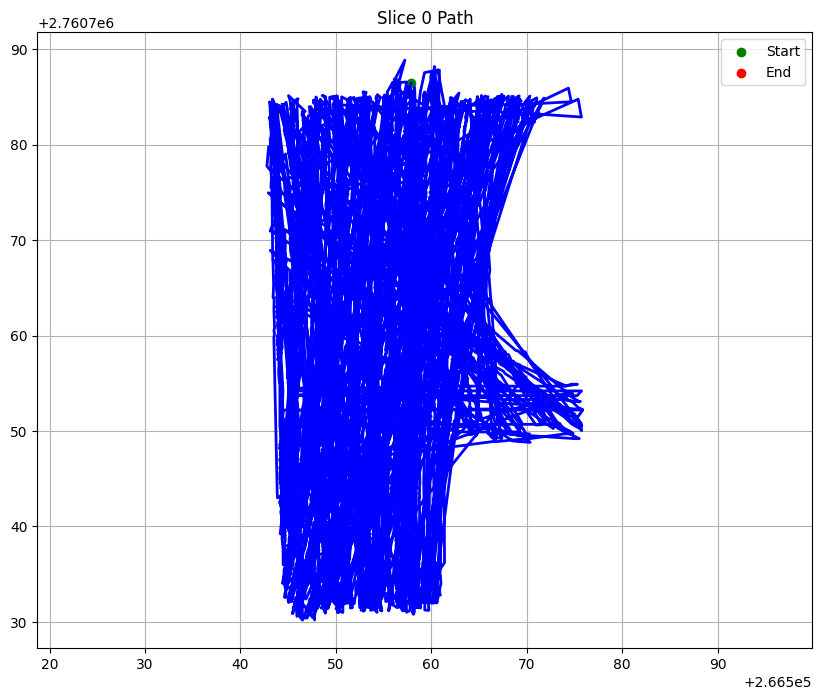

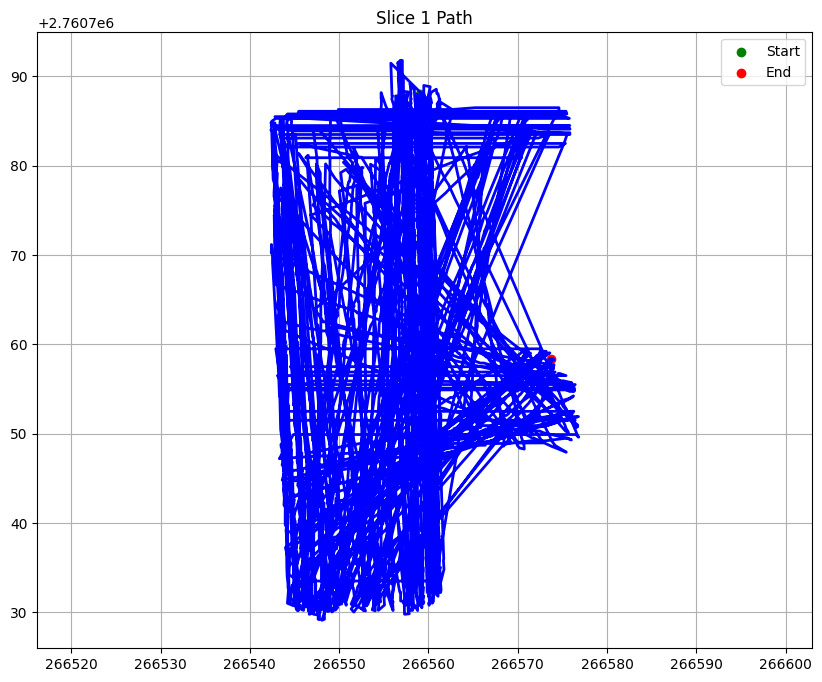

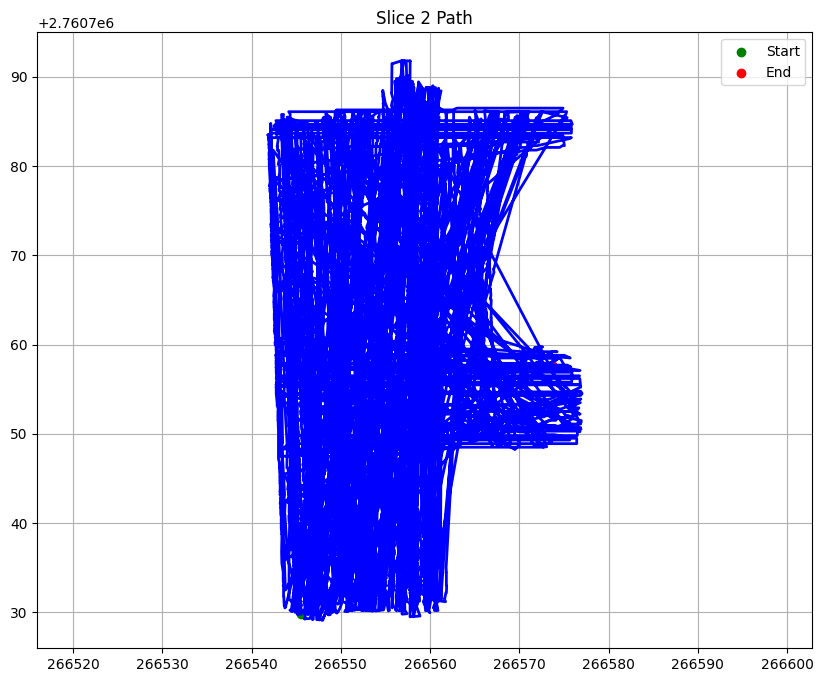

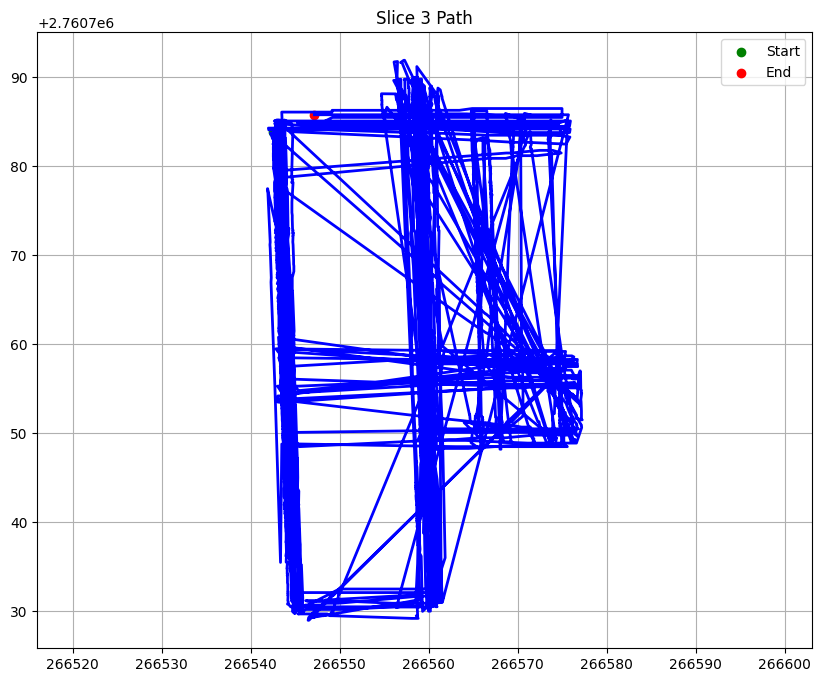

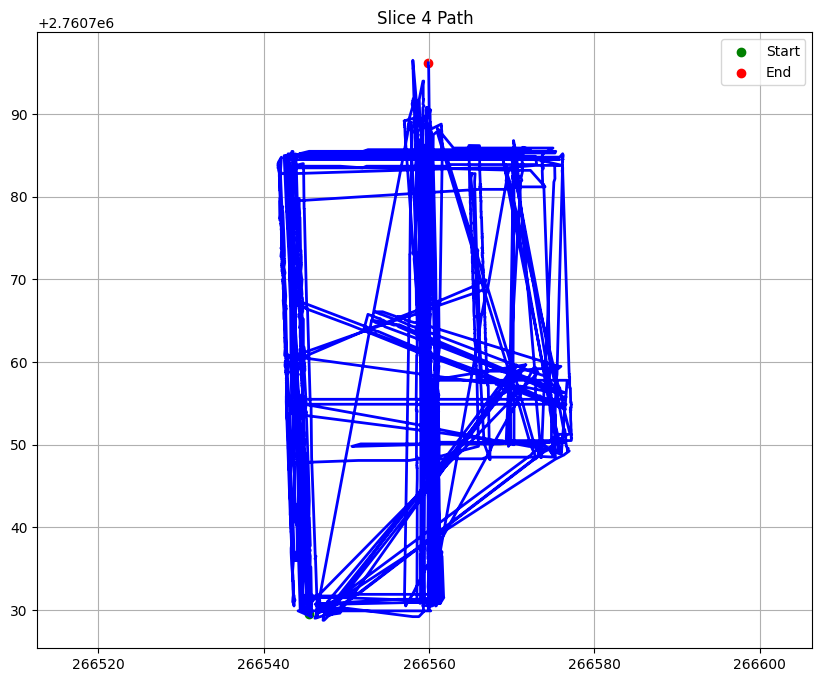

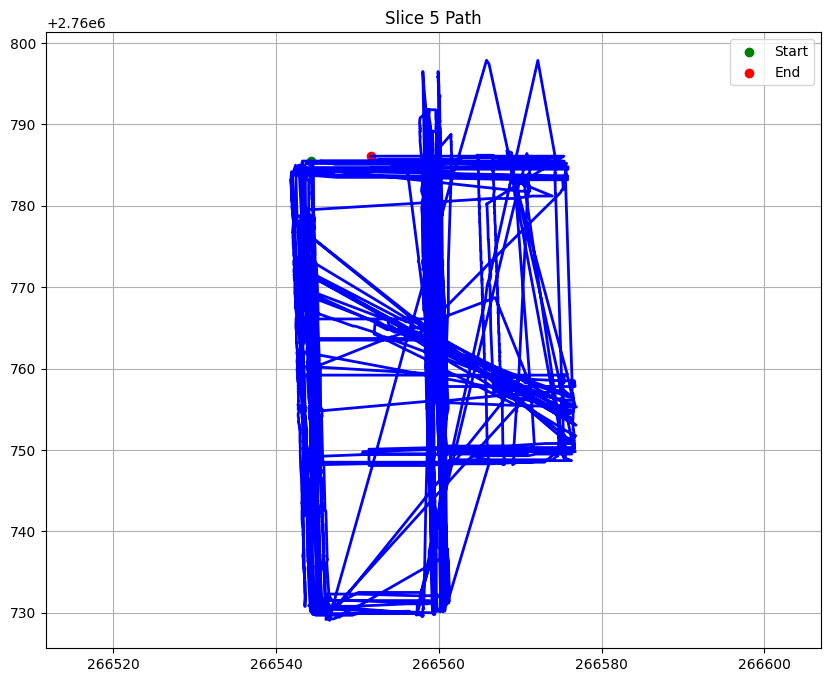

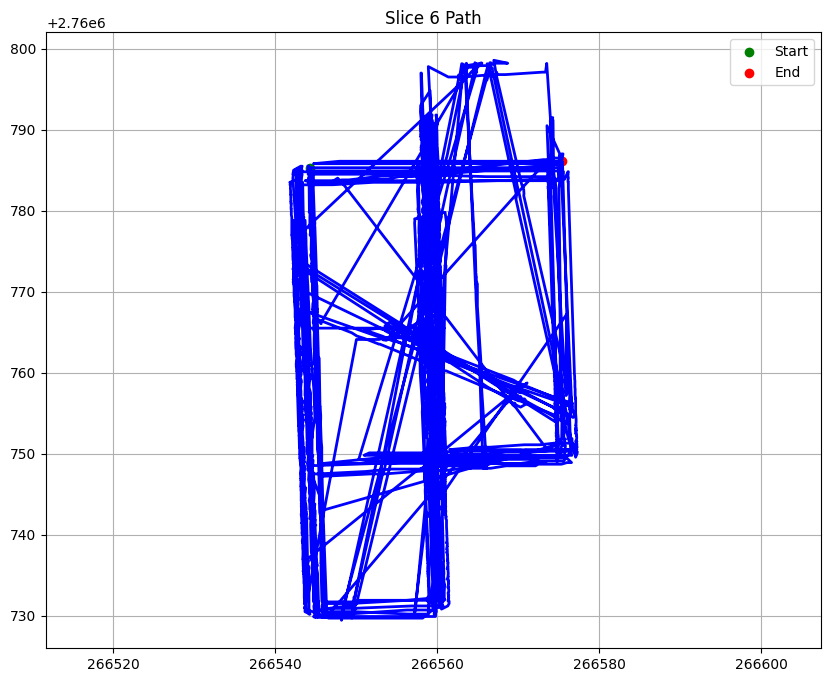

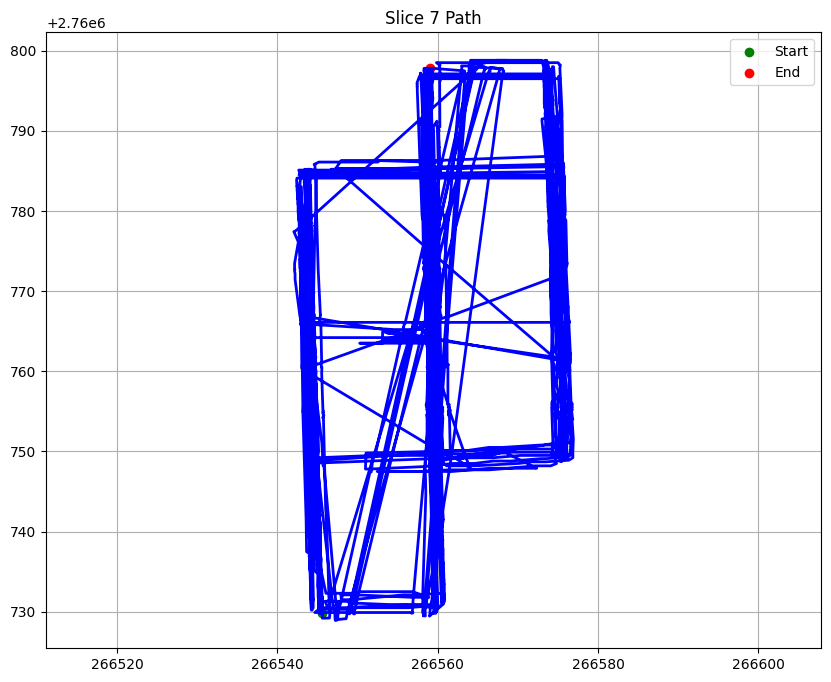

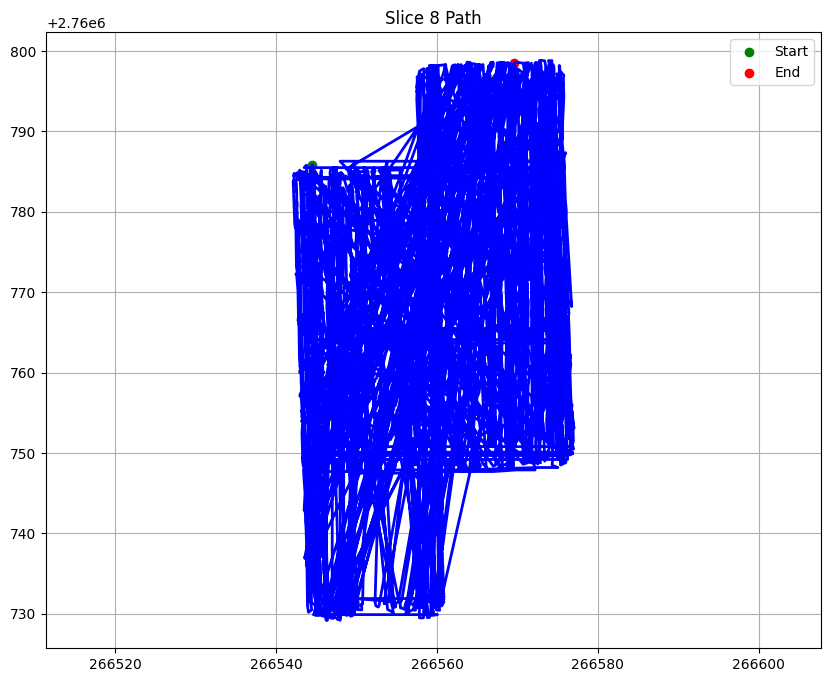

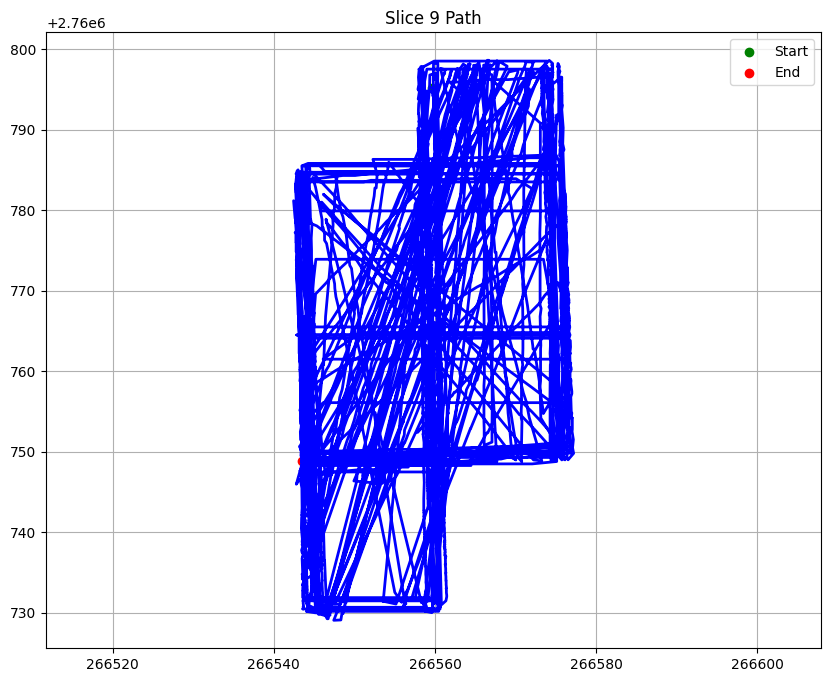

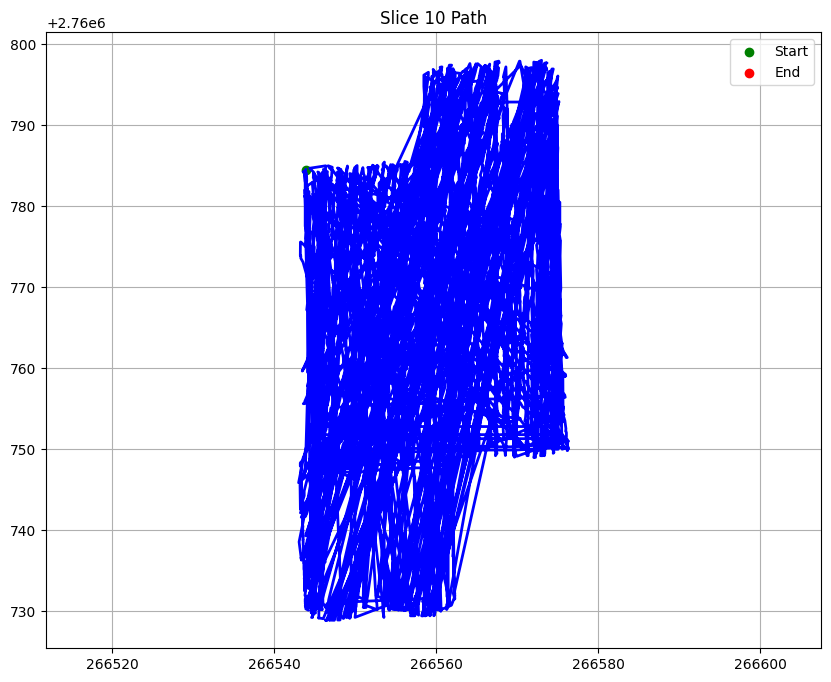

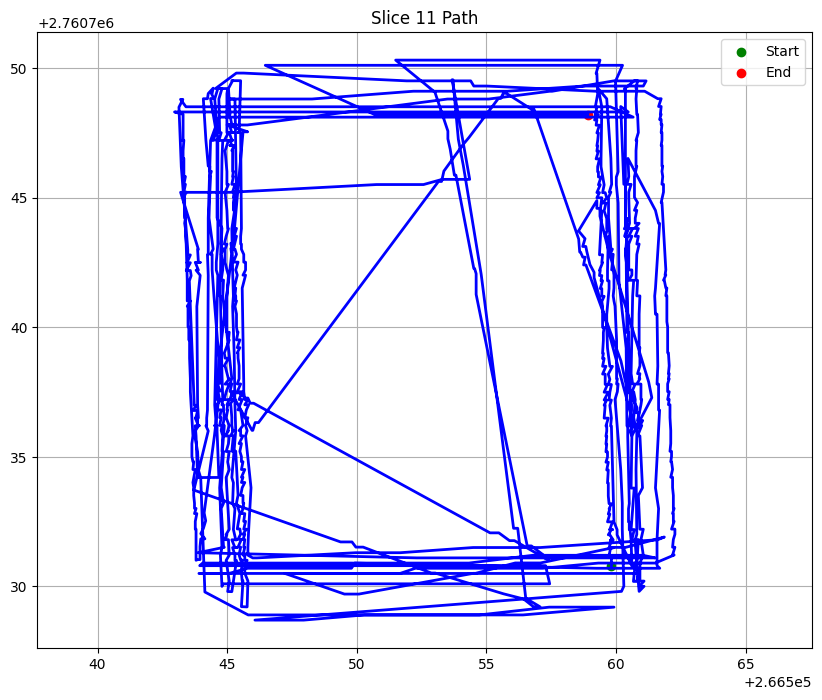

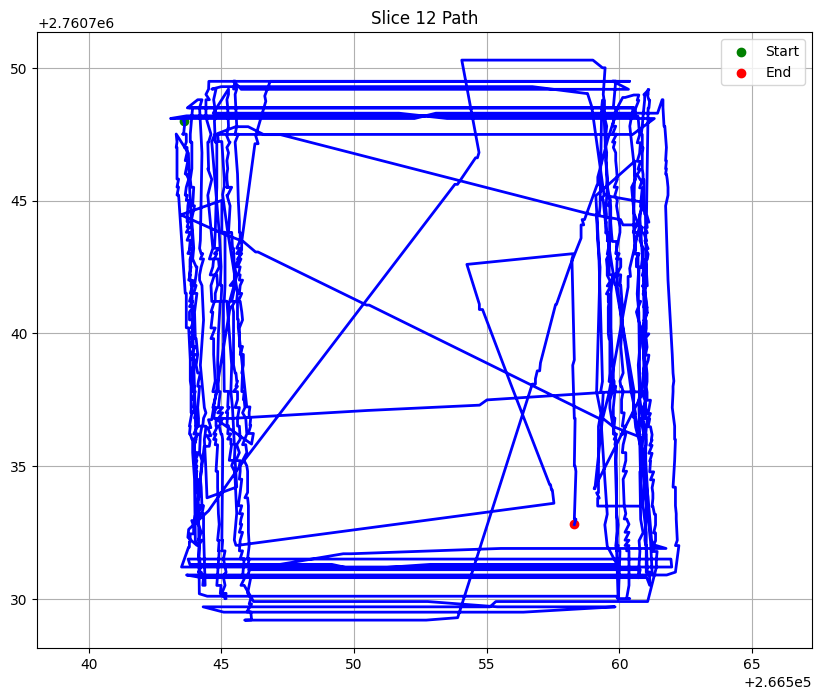

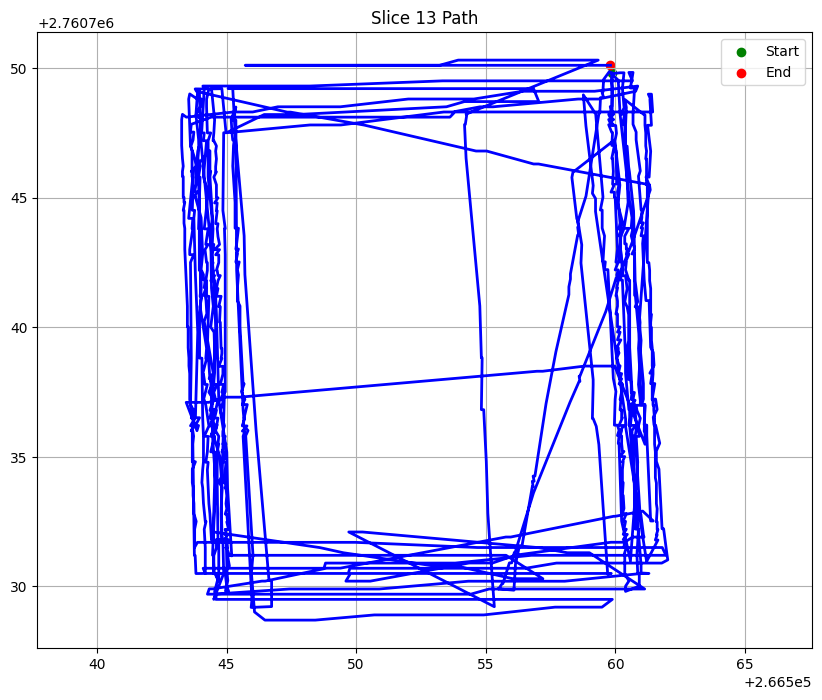

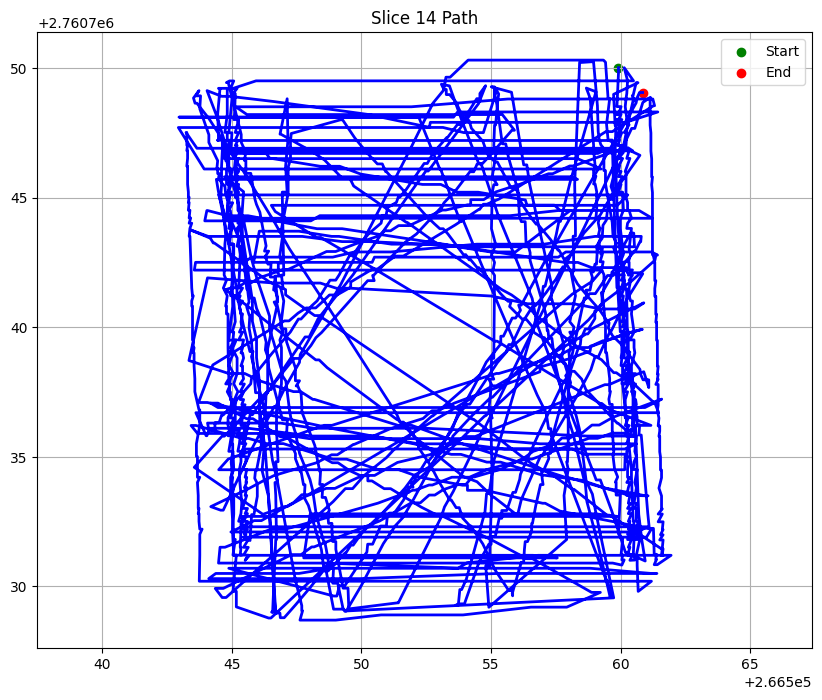

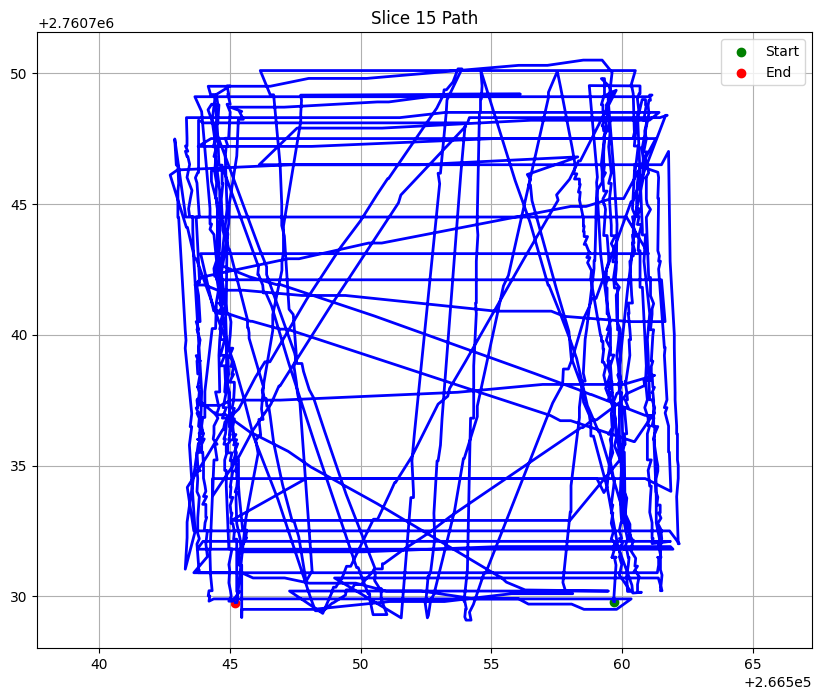

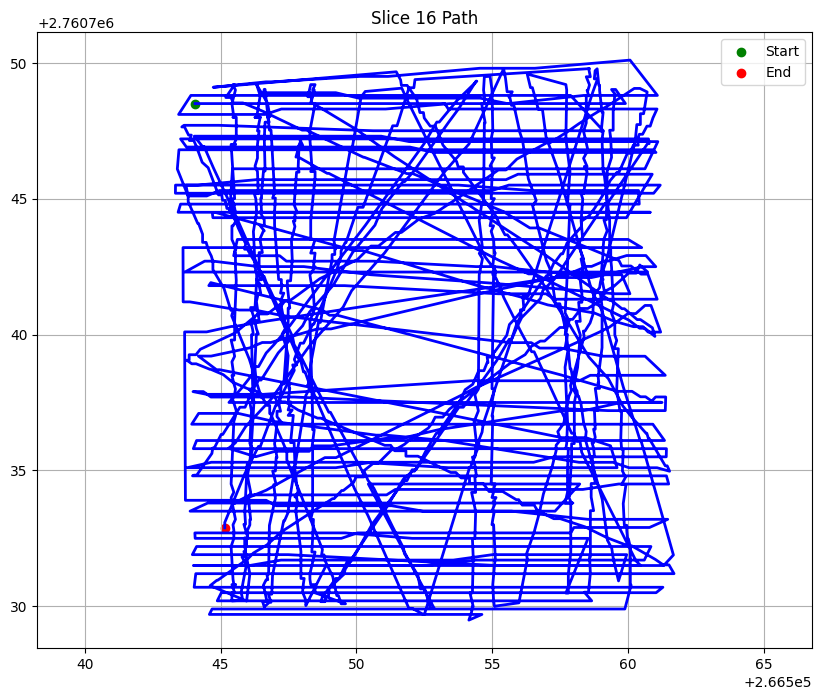

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 設定檔案路徑模板
file_template = '/content/path/to/output/slice_{}_path.npy'

# 繪製 0 到 16 的路徑
for i in range(17):  # 0 ~ 16
    file_path = file_template.format(i)  # 格式化檔案名稱
    try:
        # 載入數據
        path_data = np.load(file_path)

        # 繪製路徑
        plt.figure(figsize=(10, 8))
        plt.plot(path_data[:, 0], path_data[:, 1], 'b-', linewidth=2)
        plt.scatter(path_data[0, 0], path_data[0, 1], c='g', label='Start')  # 起點
        plt.scatter(path_data[-1, 0], path_data[-1, 1], c='r', label='End')  # 終點
        plt.title(f'Slice {i} Path')  # 添加標題
        plt.grid(True)
        plt.axis('equal')
        plt.legend()
        plt.show()
    except FileNotFoundError:
        print(f"File not found: {file_path}")
